In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from tinydb import TinyDB
import jax.numpy as jnp

import candas as can
from candas.test import QuantStudio
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'    
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["lines.linewidth"] = 2

In [3]:
def get_lg10_Q_fun(data):
    K = data.groupby("lg10_Copies")["K"].mean()
    F0_lg = data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (
        (F0_lg - np.log10(K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    lg_Q_fun = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))
    return lg_Q_fun

import jax.numpy as jnp

In [4]:
width = 3.45
height = 2.75 + 0.2
figsize = (width, height)
spotsize = 4**2
ticklabelsize = 5
labelsize = 6
linewidth = 1

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.3
mar_r = 0.3
mar_t = 0.22
mar_b = 0.275 + 0.2
ax_space = 0.075


def format_sns_axes(fig, axs, axes_dict, xticks, xlim, ylim=None, width=width, height=height, mar_b=mar_b, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, ax_space=ax_space, hline=True):
    fig.set_size_inches((width, height))

    ylim = ylim or [-1.1, 1.1]

    plt.setp(
        axs,
        ylim=ylim,
        yticks=[-1, -0.5, 0, 0.5, 1],
        xticks=xticks,
        xlim=xlim,
        title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        # if i > 0:
        #     ax.yaxis.set_tick_params(length=0)
        if hline:
            ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    for (row, col), ax in axes_dict.items():
        ax.set_title("")

        if col == 8.0:
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.set_ylabel(
                f"{row:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
            )
            if row == 5.0:
                ax2.set_ylabel(
                    f"log$_{1}$$_{0}$ Copies Competitor 2\n{row:.1f}",
                    va="bottom",
                    fontsize=labelsize,
                    rotation=270,
                    labelpad=1,
                )

        if row == 8.0:
            ax.set_title(f"{col:.1f}", fontsize=labelsize, pad=2)
            if col == 5.0:
                ax.set_title(
                    f"log$_{1}$$_{0}$ Copies Competitor 1\n{col:.1f}",
                    fontsize=labelsize,
                    pad=2,
                )

        if ax != axs[-1, 0]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        wspace=ax_space / ax_width,
        hspace=ax_space / ax_height,
    )

In [5]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn_b = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn_b.n_cycles = 50
rxn_b.compile()


def sym_bipartite(
    ref_rate,
    ref_lgQ,
    wt_rate=0.9,
    wt_pts = None,
    wt_start=1,
    wt_end=8,
    n_points=100,
    ref_drift=0,
    wt_drift=0,
    wt_lgQ_fun=None,
):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate

    rxn_b.oligo("WT").drift = wt_drift
    rxn_b.oligo("REF").drift = ref_drift

    rxn_b.oligo("REF").copies = 10**ref_lgQ

    if wt_pts is not None:
        wt_lgQ = wt_pts
    else:
        wt_lgQ = np.linspace(wt_start, wt_end, n_points)
        
    if wt_lgQ_fun is not None:
        arrays = [wt_lgQ_fun(wt_lgQ)]
    else:
        arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_b.sweep_setup = arrays, grids, pts, rxn_b.INT_idxs
    sol = rxn_b.solution_sweep()
    return wt_lgQ, sol


In [6]:
L2_500_wt1 = 'S036.5'
L2_500_wt2 = 'S036.0'

L2_500_rf1 = "S037.01.01"
L2_500_rf2 = "S036.1"

L2_500_like_wt1 = 'S036.5'
L2_500_like_wt2 = 'S036.1'

L2_500_like_rf1 = "S037.01.01"
L2_500_like_rf2 = 'S036.0'

In [7]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets_220528.pkl")
ps = ps[ps.Metric == 'mean']

# Hypothetical Parallel

Saving fig_S10A__immense_sardine in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


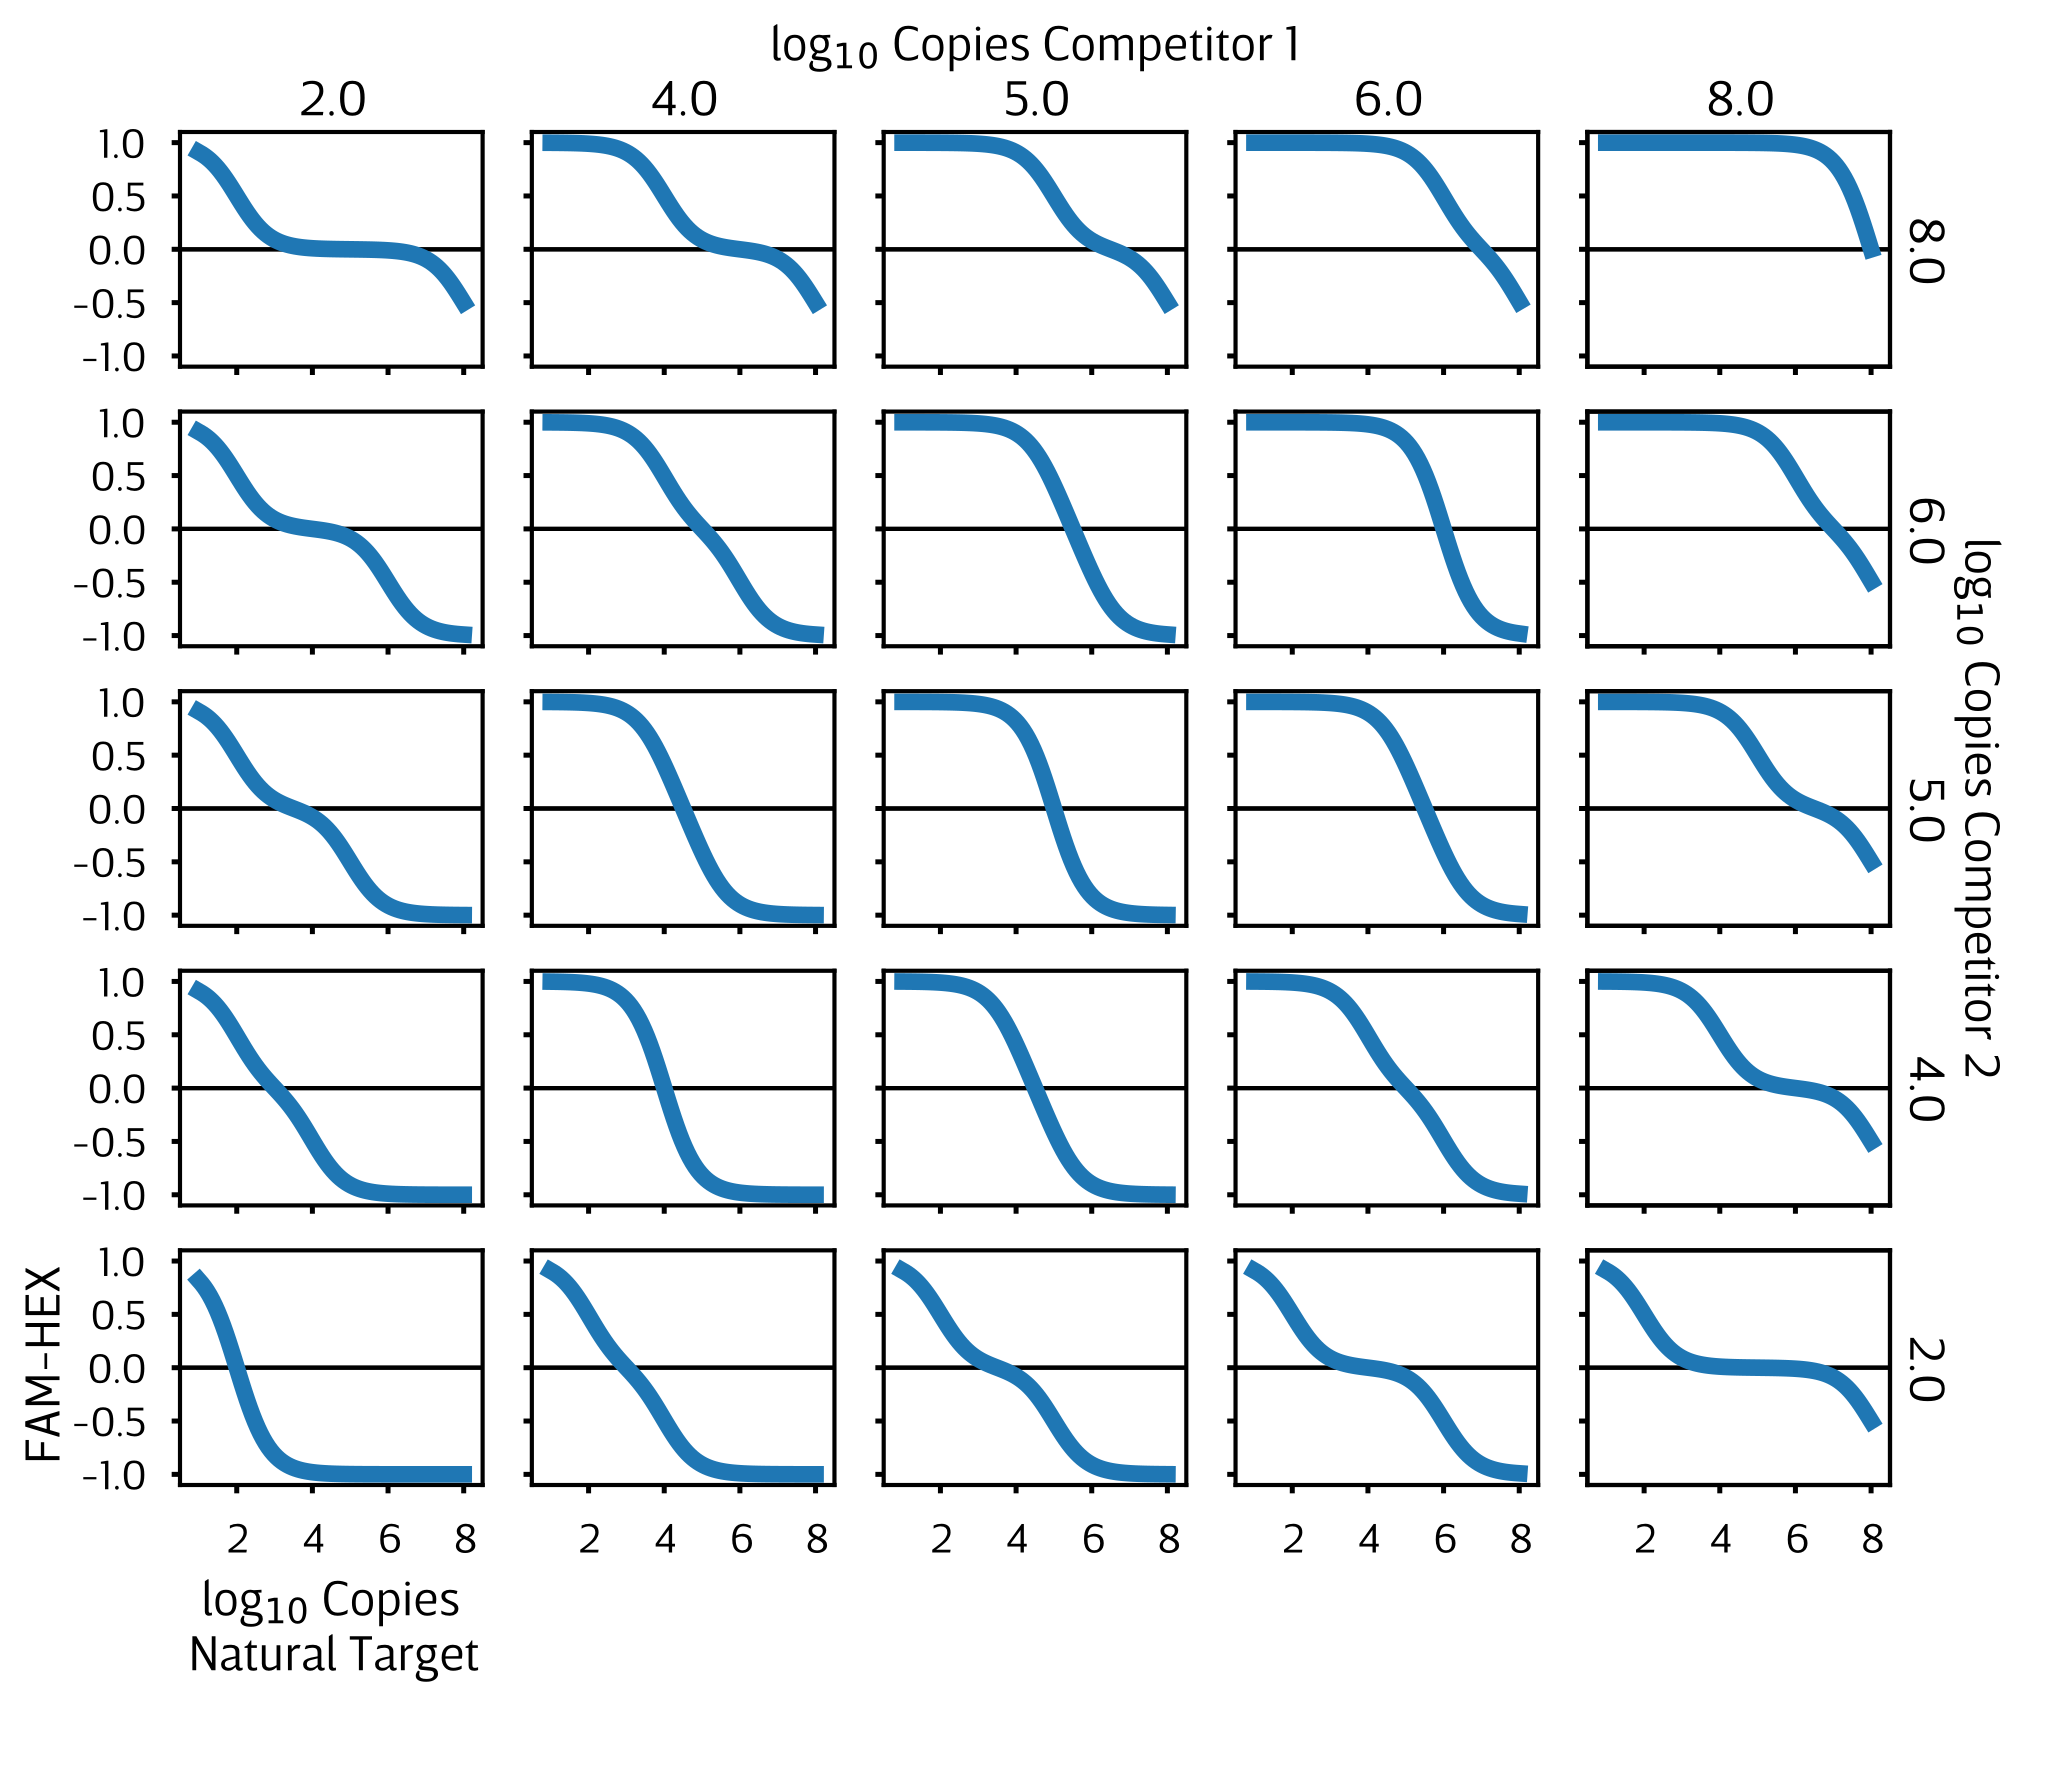

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=rf1_lgQ,
            wt_rate=1.0,
        )
        wt_lgQ, sol2 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=rf2_lgQ,
            wt_rate=1.0,
        )
        ax.plot(wt_lgQ, -(sol1+sol2)/2)
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="immense_sardine")

# Hypothetical Antiparallel

Saving fig_S10B__spicy_xantus in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


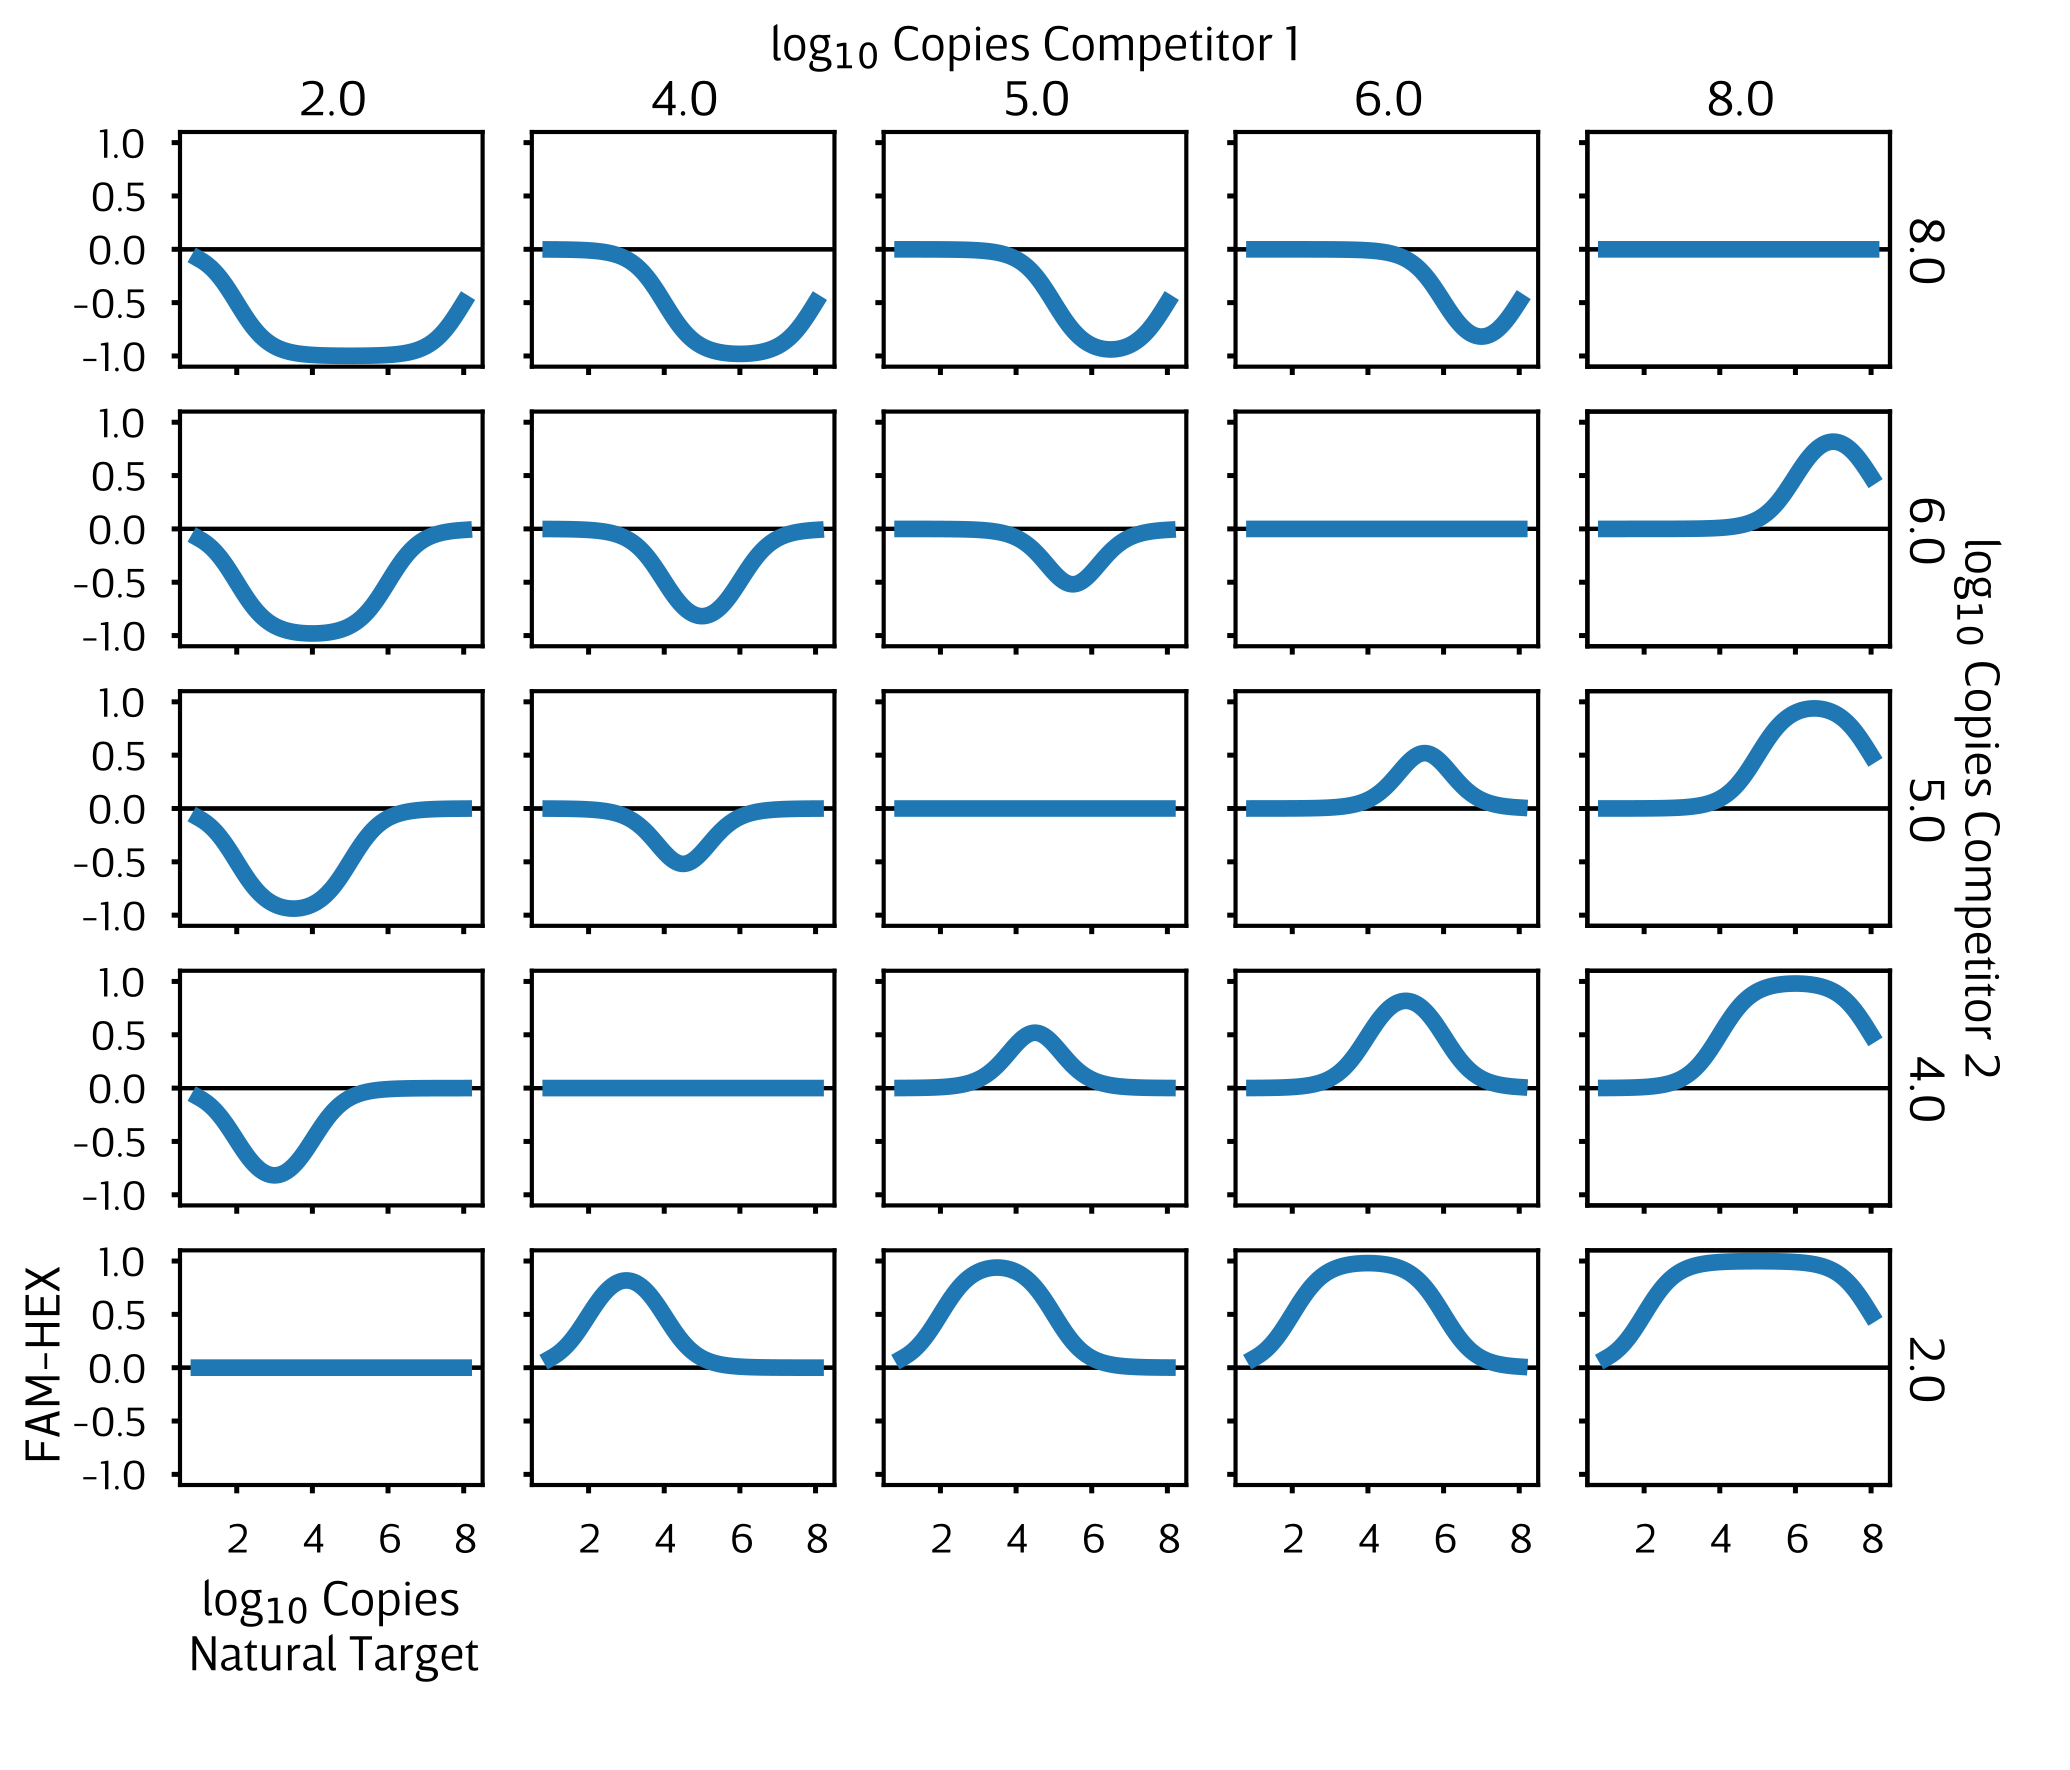

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=rf1_lgQ,
            wt_rate=1.0,
        )
        wt_lgQ, sol2 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=rf2_lgQ,
            wt_rate=1.0,
        )
        ax.plot(wt_lgQ, -(sol1-sol2)/2)
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="spicy_xantus")

# Fitted Parallel

In [10]:
db_file = data_pth / "JG074D Reaction Specifications.json"
rxn_db = TinyDB(db_file)
JG074D_rxns = pd.DataFrame(
    [rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()]
)

cmax = 50

file = data_pth / "JG074D_L2_500_like_competitor_sweep.xlsx"
JG074D = (
    QuantStudio(file, "JG074D")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

JG074D.reactions.data = JG074D.reactions.data.merge(JG074D_rxns)
for oligo in ["L2_500_like", "S037.01.01b", "S036.0"]:
    JG074D.reactions.data["lg10 " + oligo.removesuffix('b')] = np.log10(JG074D.reactions.data[oligo])

JG074D.extract_endpoints(cmax=cmax, name="FAM-HEX")
endpoints_D = JG074D.endpoints
endpoints_D = endpoints_D[endpoints_D.Reporter == "FAM"]

Saving fig_S10C__nearby_elephant in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


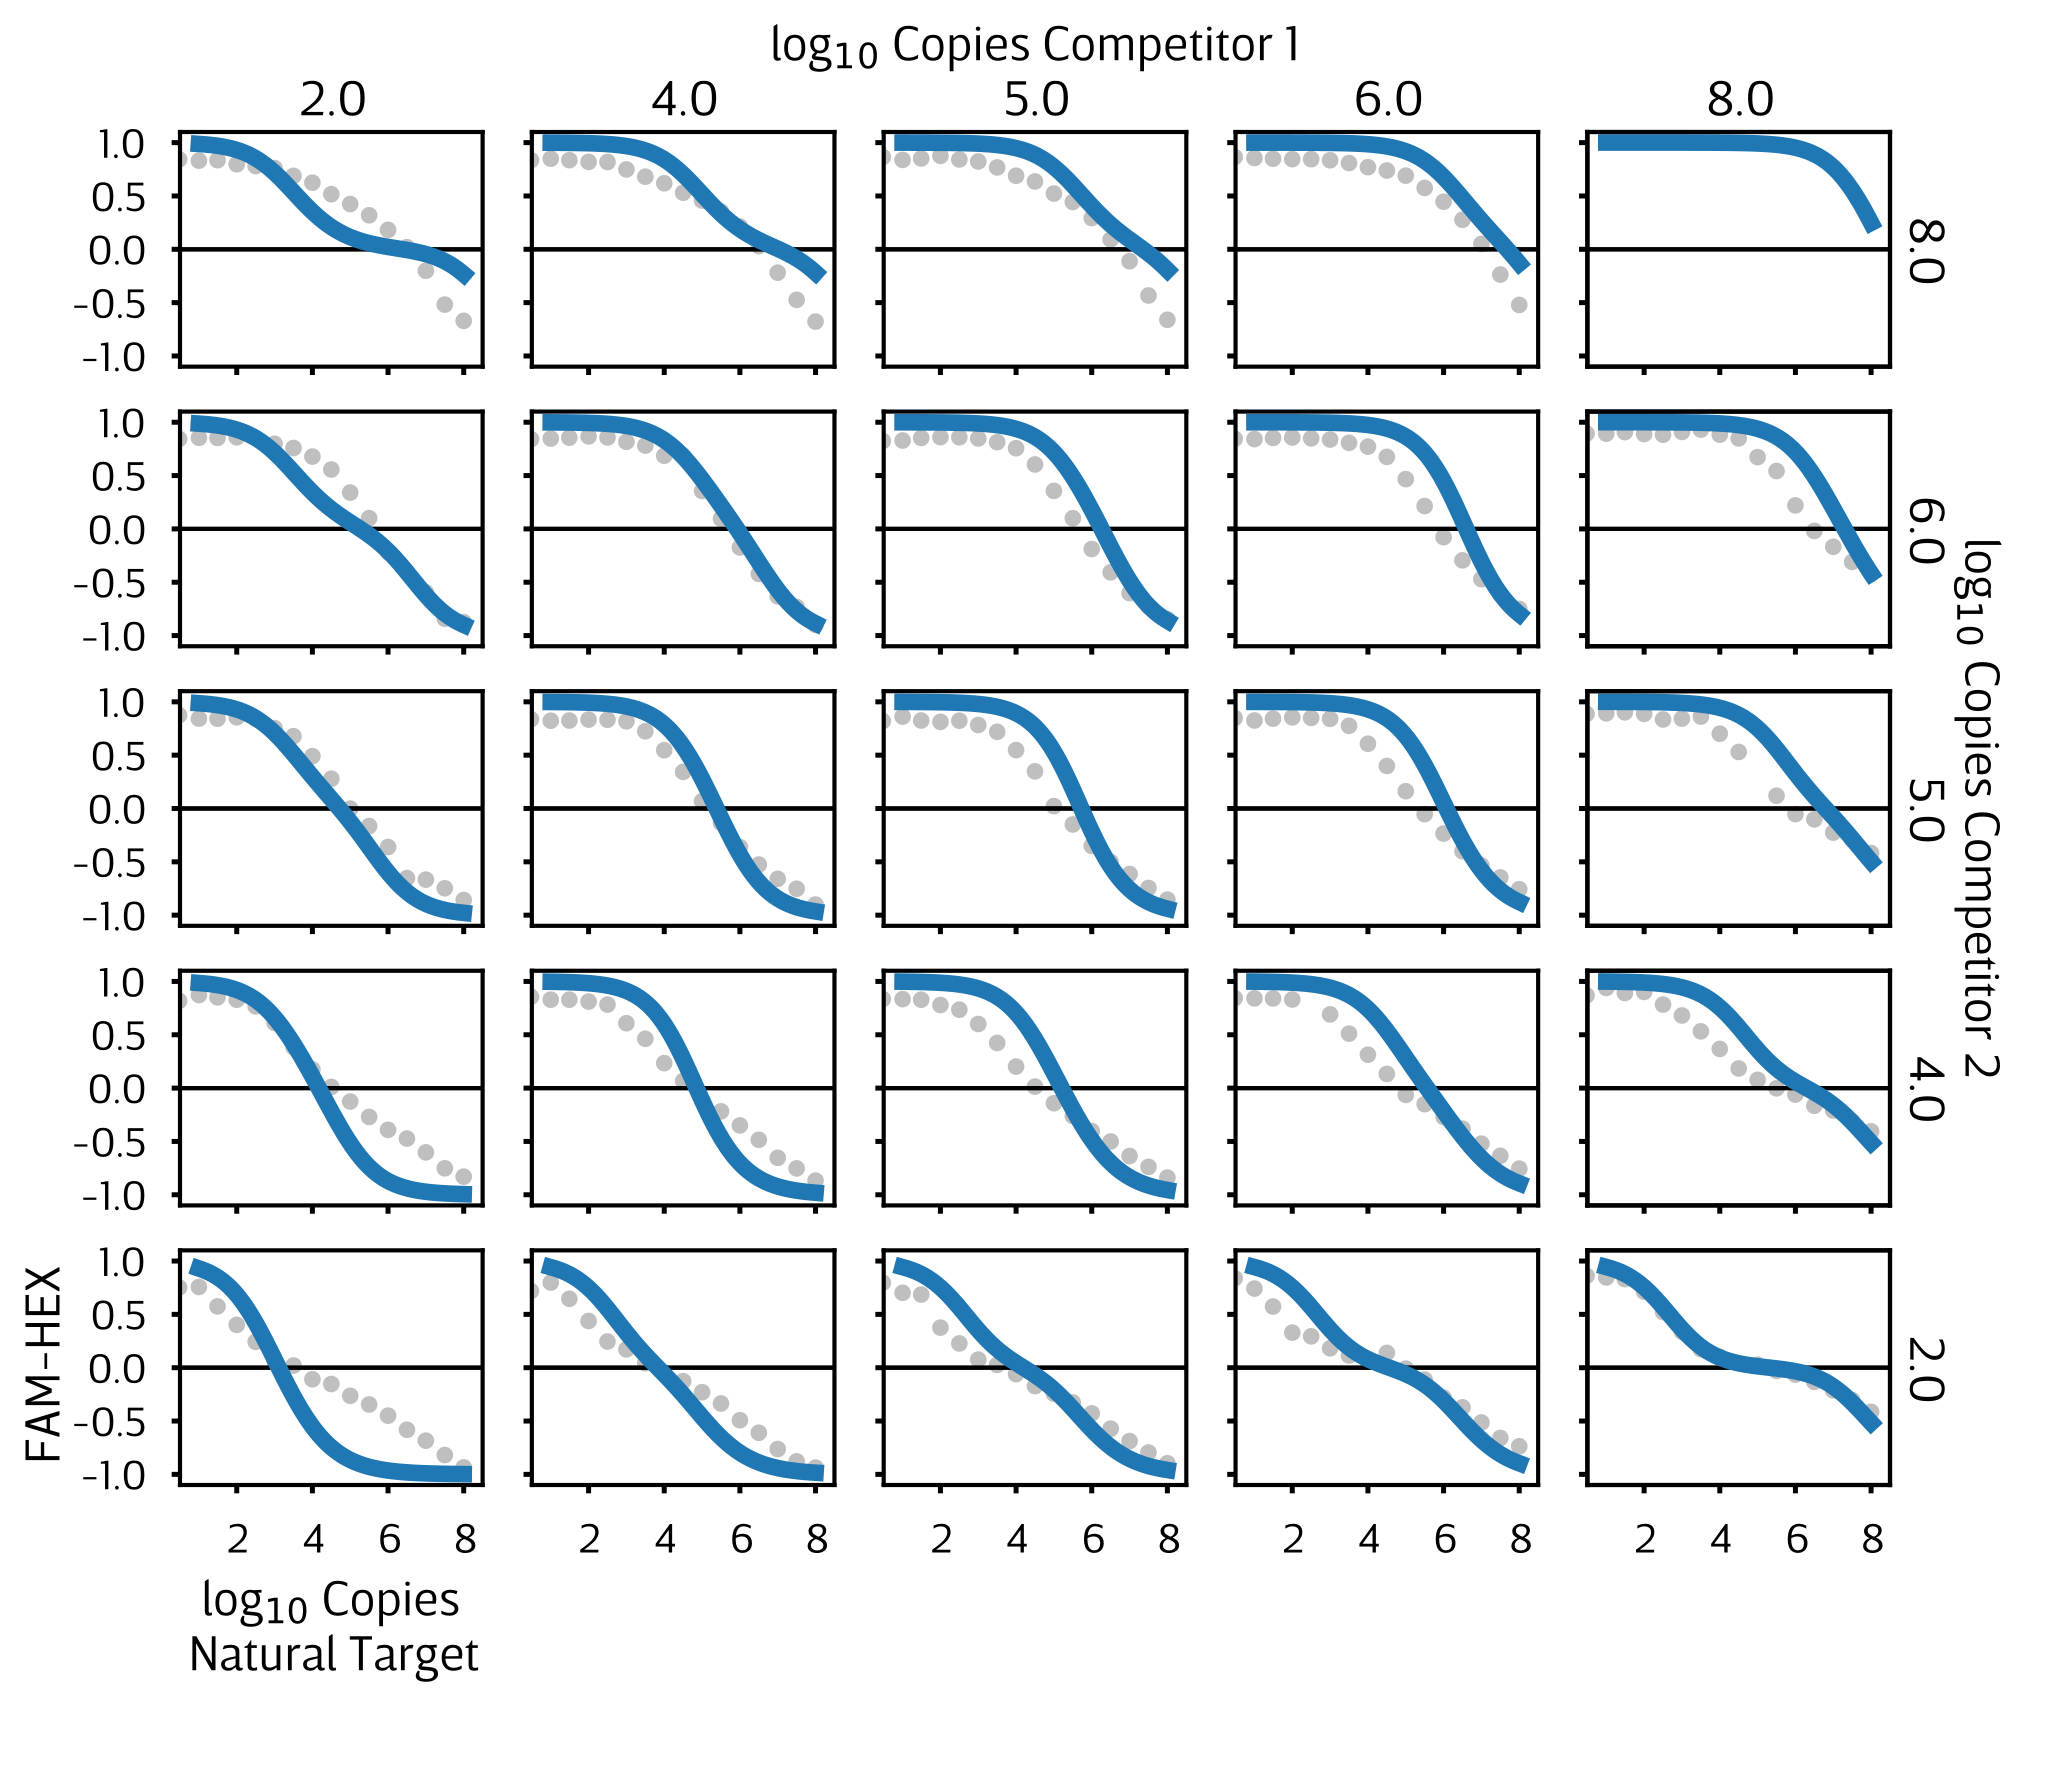

In [11]:
wt1_data = ps[ps.Target == L2_500_like_wt1]
wt2_data = ps[ps.Target == L2_500_like_wt2]
rf1_data = ps[ps.Target == L2_500_like_rf1]
rf2_data = ps[ps.Target == L2_500_like_rf2]

wt1_rate = wt1_data["r"].mean()
wt2_rate = wt2_data["r"].mean()
rf1_rate = rf1_data["r"].mean()
rf2_rate = rf2_data["r"].mean()

wt1_drift = wt1_data["m"].mean()
wt2_drift = wt2_data["m"].mean()
rf1_drift = rf1_data["m"].mean()
rf2_drift = rf2_data["m"].mean()

wt1_lgQ_fun = get_lg10_Q_fun(wt1_data)
wt2_lgQ_fun = get_lg10_Q_fun(wt2_data)
rf1_lgQ_fun = get_lg10_Q_fun(rf1_data)
rf2_lgQ_fun = get_lg10_Q_fun(rf2_data)

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

rmses_parallel= {}

for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            wt_rate=wt1_rate,
            ref_rate=rf1_rate,
            ref_lgQ=rf1_lgQ_fun(rf1_lgQ),
            wt_drift=wt1_drift,
            ref_drift=rf1_drift,
            wt_lgQ_fun=wt1_lgQ_fun,
        )
        wt_lgQ, sol2 = sym_bipartite(
            wt_rate=wt2_rate,
            ref_rate=rf2_rate,
            ref_lgQ=rf2_lgQ_fun(rf2_lgQ),
            wt_drift=wt2_drift,
            ref_drift=rf2_drift,
            wt_lgQ_fun=wt2_lgQ_fun,
        )
        ax.plot(wt_lgQ, -(sol1+sol2)/2)
    
        these_endpoints = endpoints_D[
            (endpoints_D["lg10 " + L2_500_like_rf1] == rf1_lgQ)
            & (endpoints_D["lg10 " + L2_500_like_rf2] == rf2_lgQ)
        ]
        
        if not these_endpoints.empty:
            ax.scatter(
                these_endpoints["lg10 L2_500_like"],
                these_endpoints["FAM-HEX"],
                s=4,
                color="grey",
                edgecolor="none",
                alpha=0.5,
                zorder=-10,
            )
            wt_lgQ, sol1 = sym_bipartite(
                wt_rate=wt1_rate,
                ref_rate=rf1_rate,
                ref_lgQ=rf1_lgQ_fun(rf1_lgQ),
                wt_drift=wt1_drift,
                ref_drift=rf1_drift,
                wt_lgQ_fun=wt1_lgQ_fun,
                wt_pts=these_endpoints["lg10 L2_500_like"],
            )
            wt_lgQ, sol2 = sym_bipartite(
                wt_rate=wt2_rate,
                ref_rate=rf2_rate,
                ref_lgQ=rf2_lgQ_fun(rf2_lgQ),
                wt_drift=wt2_drift,
                ref_drift=rf2_drift,
                wt_lgQ_fun=wt2_lgQ_fun,
                wt_pts=these_endpoints["lg10 L2_500_like"],
            )
        
            rmse = np.sqrt(np.mean((-(sol1+sol2)/2 - these_endpoints["FAM-HEX"]) ** 2))
            rmses_parallel[(rf2_lgQ, rf1_lgQ)] = rmse
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="nearby_elephant")

# Fitted Antiparallel

In [12]:
db_file = data_pth / "JG074C Reaction Specifications.json"
rxn_db = TinyDB(db_file)
JG074C_rxns = pd.DataFrame(
    [rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()]
)

cmax = 50

file = data_pth / "JG074C_L2_500_competitor_sweep.xlsx"
JG074C = (
    QuantStudio(file, "JG074C")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore("HEX")
)

JG074C.reactions.data = JG074C.reactions.data.merge(JG074C_rxns)
for oligo in ["L2_500", "S037.01.01b", "S036.1b"]:
    JG074C.reactions.data["lg10 " + oligo.removesuffix('b')] = np.log10(JG074C.reactions.data[oligo])

# One competitor was clearly missing from this mastermix
JG074C.reactions.wide = JG074C.reactions.wide[
    ~(
        (JG074C.reactions.wide["lg10 S037.01.01"] == 8.0)
        & (JG074C.reactions.wide["lg10 S036.1"] == 2.0)
    )
]

JG074C.extract_endpoints(cmax=cmax, name="FAM-HEX")
endpoints_C = JG074C.endpoints
endpoints_C = endpoints_C[endpoints_C.Reporter == "FAM"]

Saving fig_S10D__remote_ferret in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


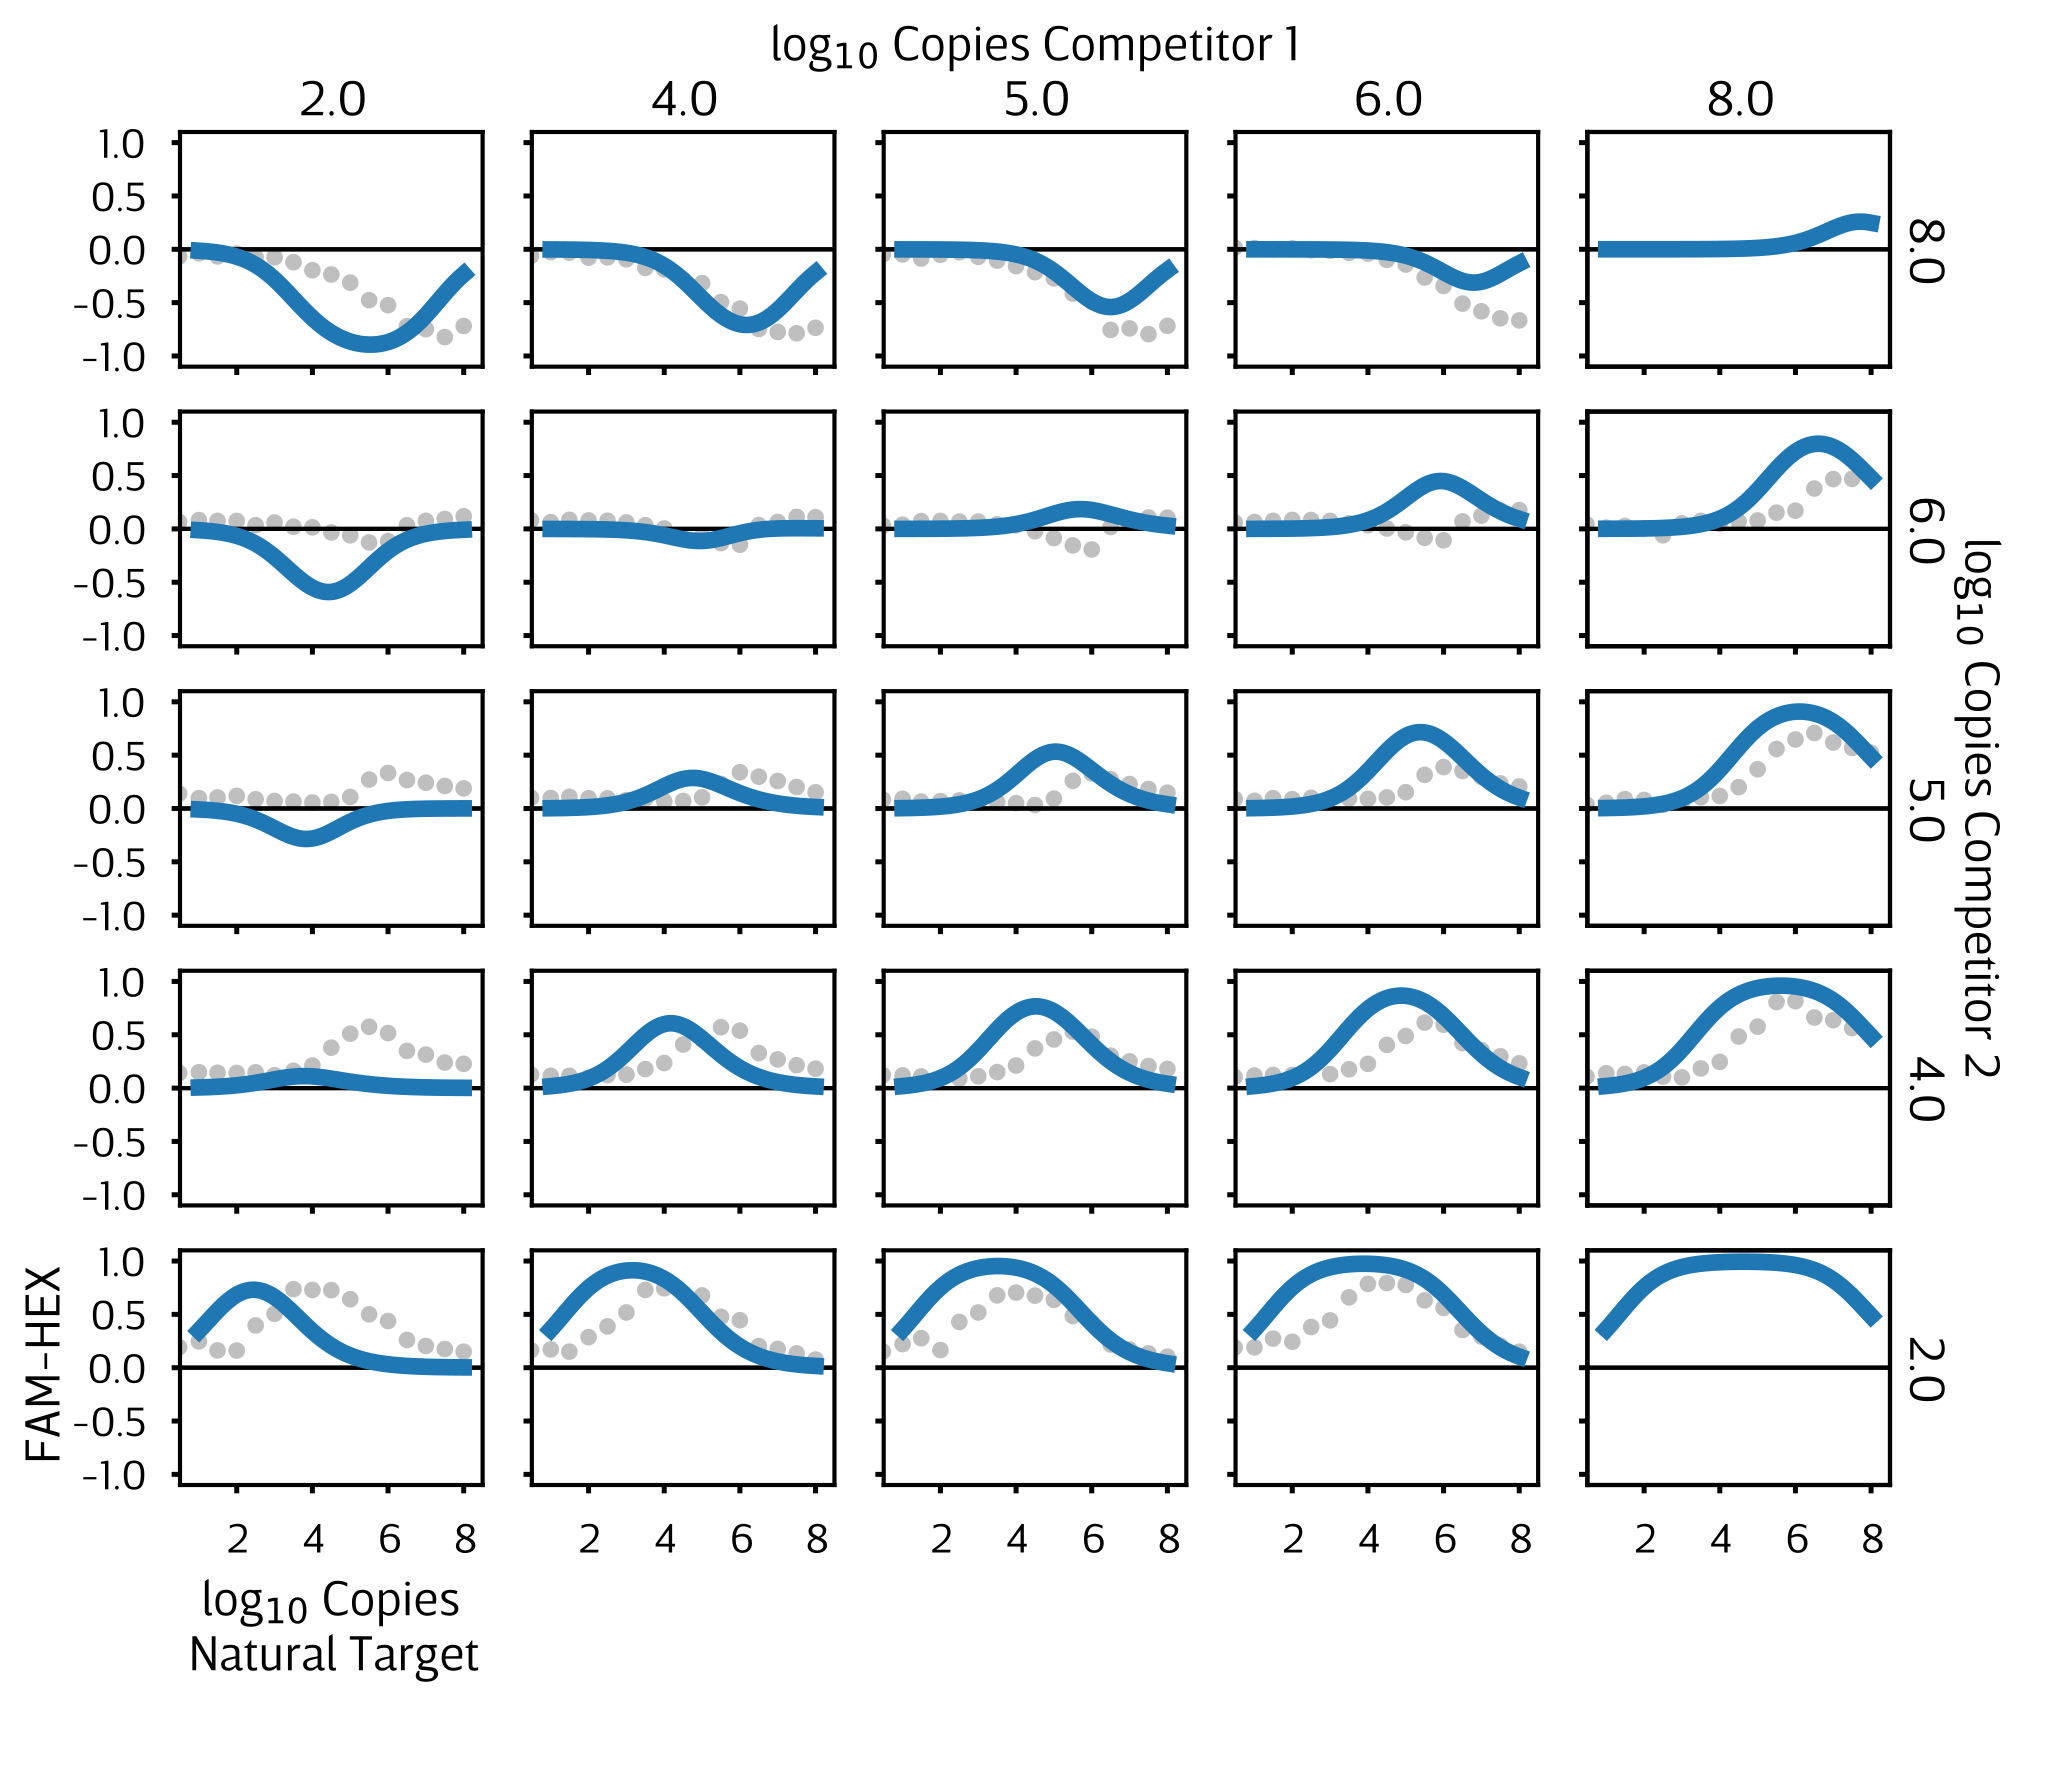

In [13]:
wt1_data = ps[ps.Target == L2_500_wt1]
wt2_data = ps[ps.Target == L2_500_wt2]
rf1_data = ps[ps.Target == L2_500_rf1]
rf2_data = ps[ps.Target == L2_500_rf2]

wt1_rate = wt1_data["r"].mean()
wt2_rate = wt2_data["r"].mean()
rf1_rate = rf1_data["r"].mean()
rf2_rate = rf2_data["r"].mean()

wt1_drift = wt1_data["m"].mean()
wt2_drift = wt2_data["m"].mean()
rf1_drift = rf1_data["m"].mean()
rf2_drift = rf2_data["m"].mean()

wt1_lgQ_fun = get_lg10_Q_fun(wt1_data)
wt2_lgQ_fun = get_lg10_Q_fun(wt2_data)
rf1_lgQ_fun = get_lg10_Q_fun(rf1_data)
rf2_lgQ_fun = get_lg10_Q_fun(rf2_data)

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

rmses_antiparallel = {}

for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            wt_rate=wt1_rate,
            ref_rate=rf1_rate,
            ref_lgQ=rf1_lgQ_fun(rf1_lgQ),
            wt_drift=wt1_drift,
            ref_drift=rf1_drift,
            wt_lgQ_fun=wt1_lgQ_fun,
        )
        wt_lgQ, sol2 = sym_bipartite(
            wt_rate=wt2_rate,
            ref_rate=rf2_rate,
            ref_lgQ=rf2_lgQ_fun(rf2_lgQ),
            wt_drift=wt2_drift,
            ref_drift=rf2_drift,
            wt_lgQ_fun=wt2_lgQ_fun,
        )
        ax.plot(wt_lgQ, -(sol1-sol2)/2)
    
        these_endpoints = endpoints_C[
            (endpoints_C["lg10 " + L2_500_rf1] == rf1_lgQ)
            & (endpoints_C["lg10 " + L2_500_rf2] == rf2_lgQ)
        ]
        
        if not these_endpoints.empty:
            ax.scatter(
                these_endpoints["lg10 L2_500"],
                these_endpoints["FAM-HEX"],
                s=4,
                color="grey",
                edgecolor="none",
                alpha=0.5,
                zorder=-10,
            )
            wt_lgQ, sol1 = sym_bipartite(
                wt_rate=wt1_rate,
                ref_rate=rf1_rate,
                ref_lgQ=rf1_lgQ_fun(rf1_lgQ),
                wt_drift=wt1_drift,
                ref_drift=rf1_drift,
                wt_lgQ_fun=wt1_lgQ_fun,
                wt_pts=these_endpoints["lg10 L2_500"],
            )
            wt_lgQ, sol2 = sym_bipartite(
                wt_rate=wt2_rate,
                ref_rate=rf2_rate,
                ref_lgQ=rf2_lgQ_fun(rf2_lgQ),
                wt_drift=wt2_drift,
                ref_drift=rf2_drift,
                wt_lgQ_fun=wt2_lgQ_fun,
                wt_pts=these_endpoints["lg10 L2_500"],
            )
        
            rmse = np.sqrt(np.mean((-(sol1-sol2)/2 - these_endpoints["FAM-HEX"]) ** 2))
            rmses_antiparallel[(rf2_lgQ, rf1_lgQ)] = rmse
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="remote_ferret")

# RMSE plots

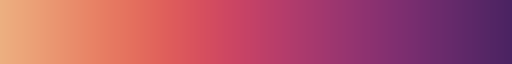

In [14]:
from matplotlib import cm
from matplotlib import colormaps

all_rmses = np.array(list(rmses_parallel.values()) + list(rmses_antiparallel.values()))

rmse_norm = cm.colors.Normalize()
rmse_norm(all_rmses)

cmap = colormaps["flare"]
cmap

RMSE Parallel: 0.22 ± 0.06
Saving fig_S10E__linear_grasshopper in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


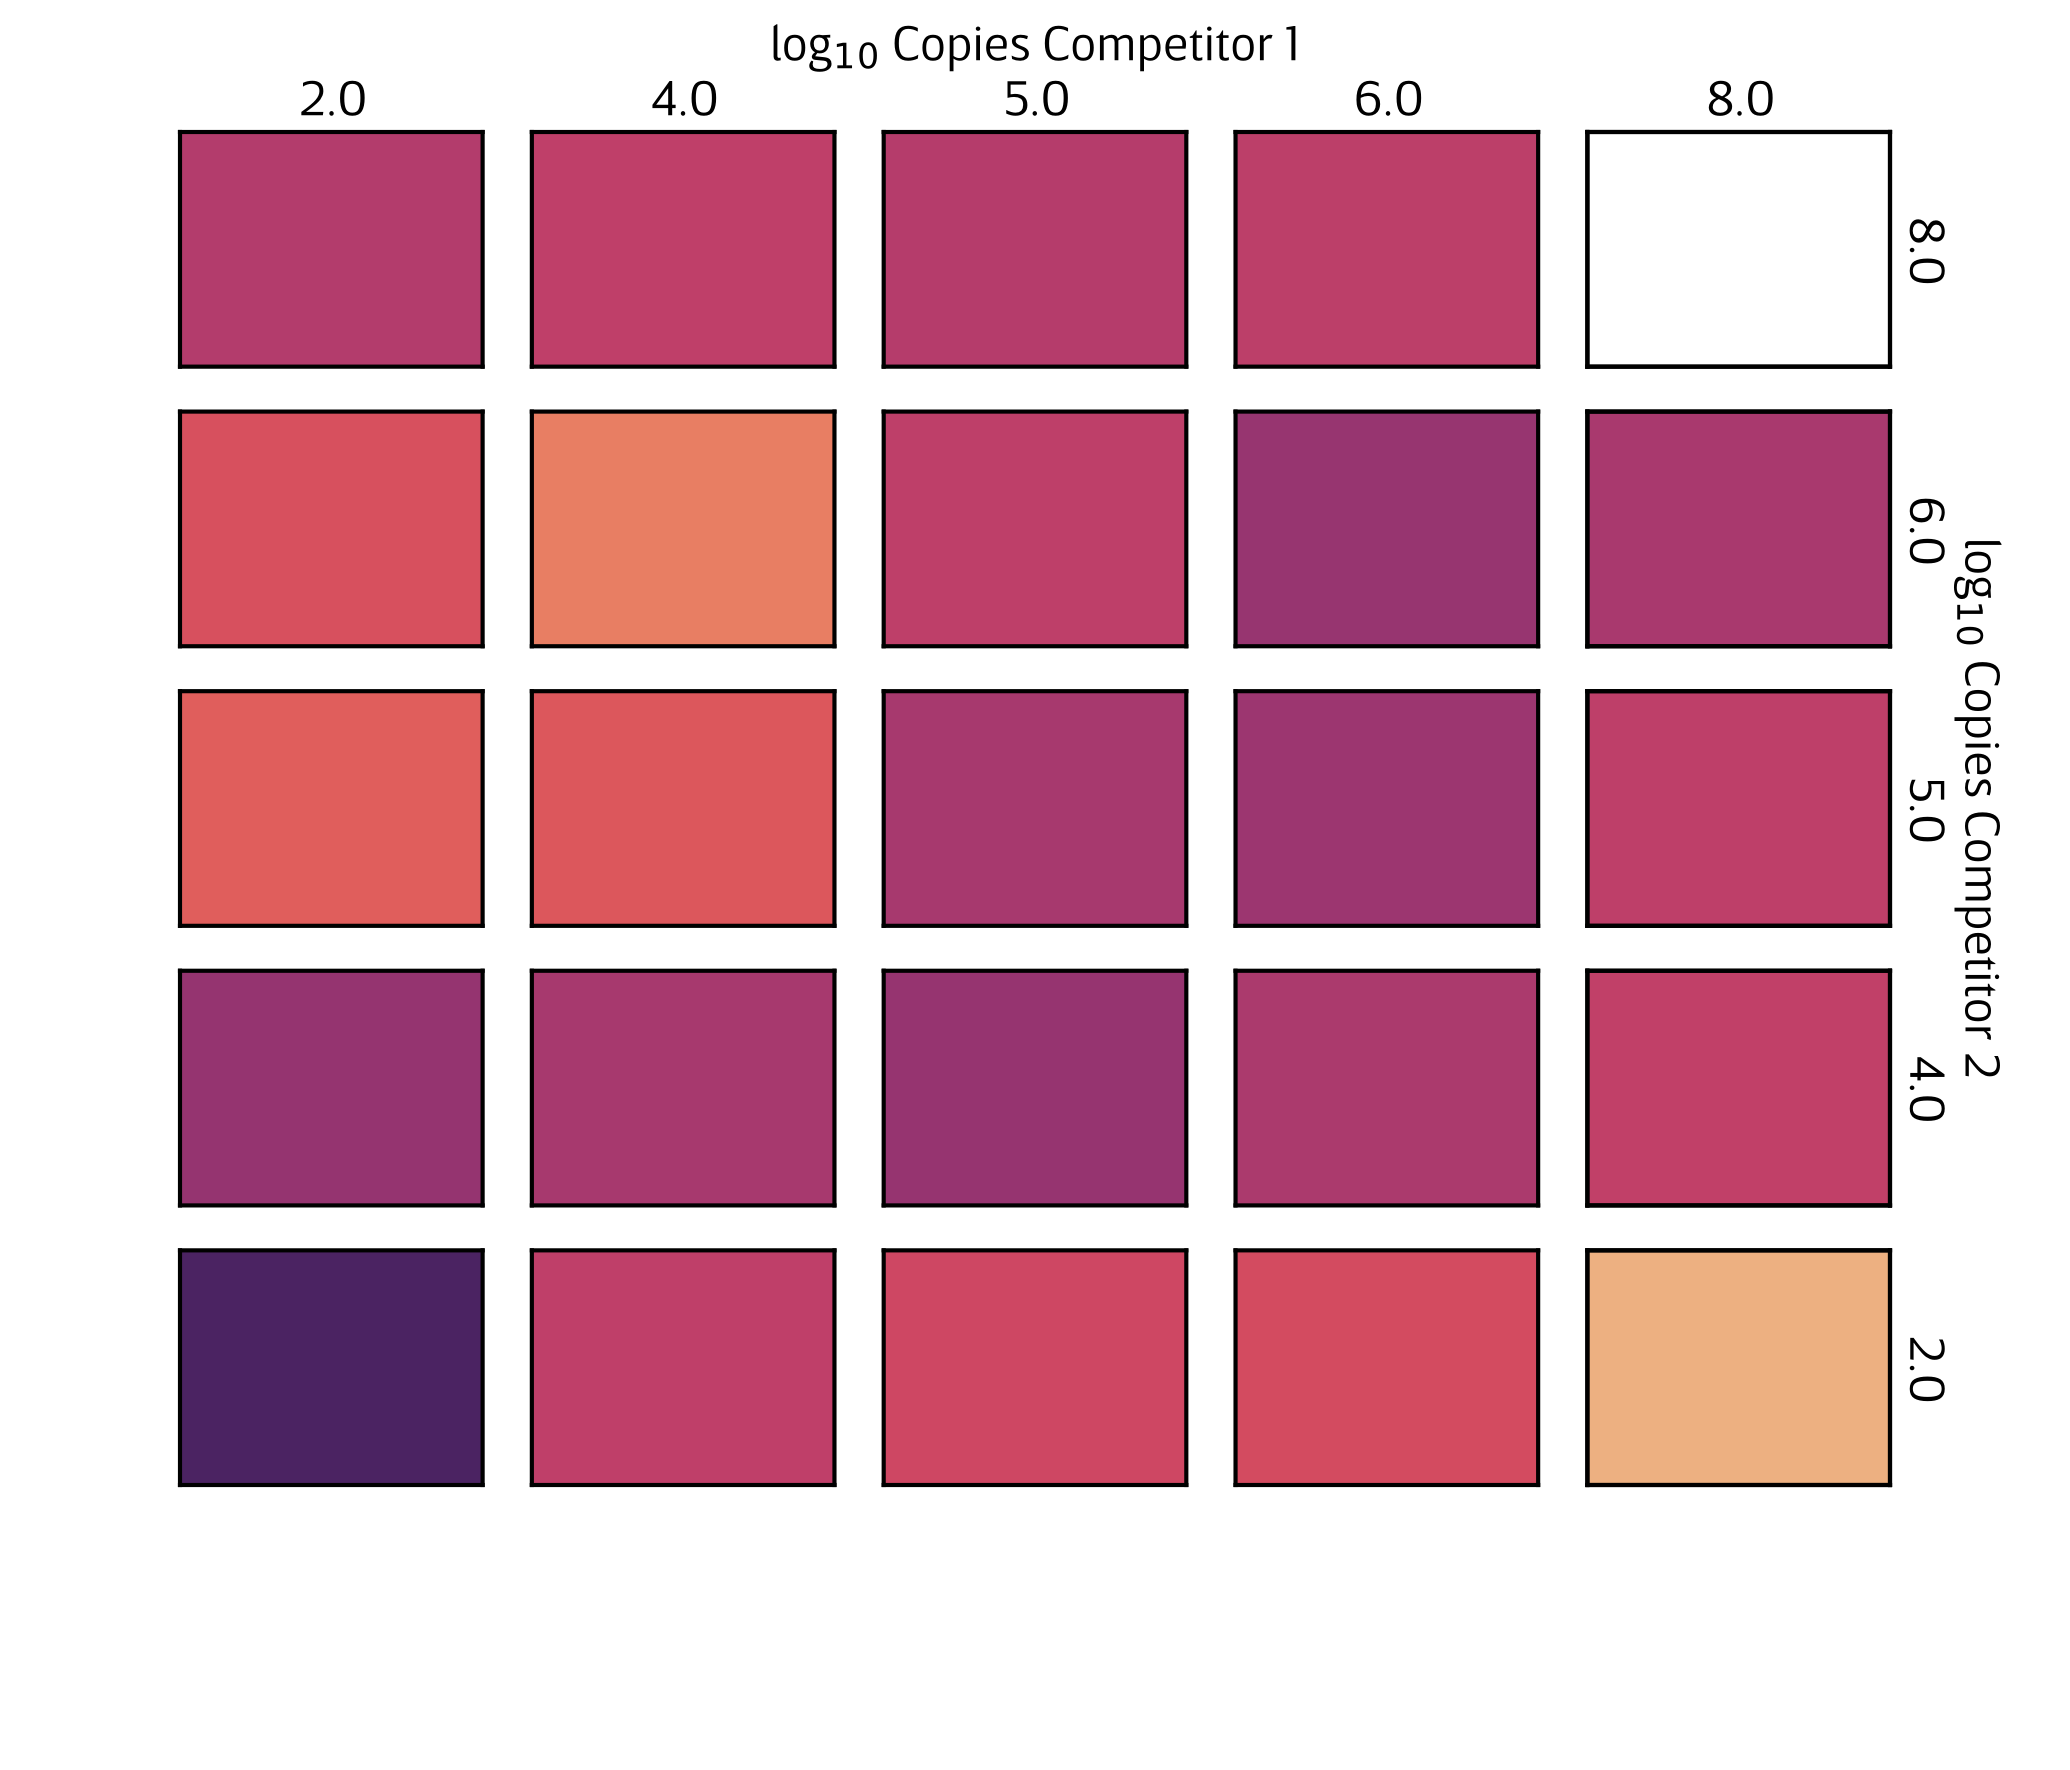

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}



for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
    if (rf2_lgQ, rf1_lgQ) in rmses_parallel:
        rmse = rmses_parallel[(rf2_lgQ, rf1_lgQ)]
    else:
        ax.set_facecolor('white')
        continue
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    
format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5], hline=False)

plt.setp(
    axs,
    yticks=[],
    xticks=[],
)

print(f"RMSE Parallel: {np.mean(list(rmses_parallel.values())):.2f} ± {np.std(list(rmses_parallel.values())):.2f}")

savefig(plt.gcf(), alias="linear_grasshopper", transparent_svg=False)

RMSE Antiparallel: 0.23 ± 0.06
Saving fig_S10F__jagged_hermitcrab in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


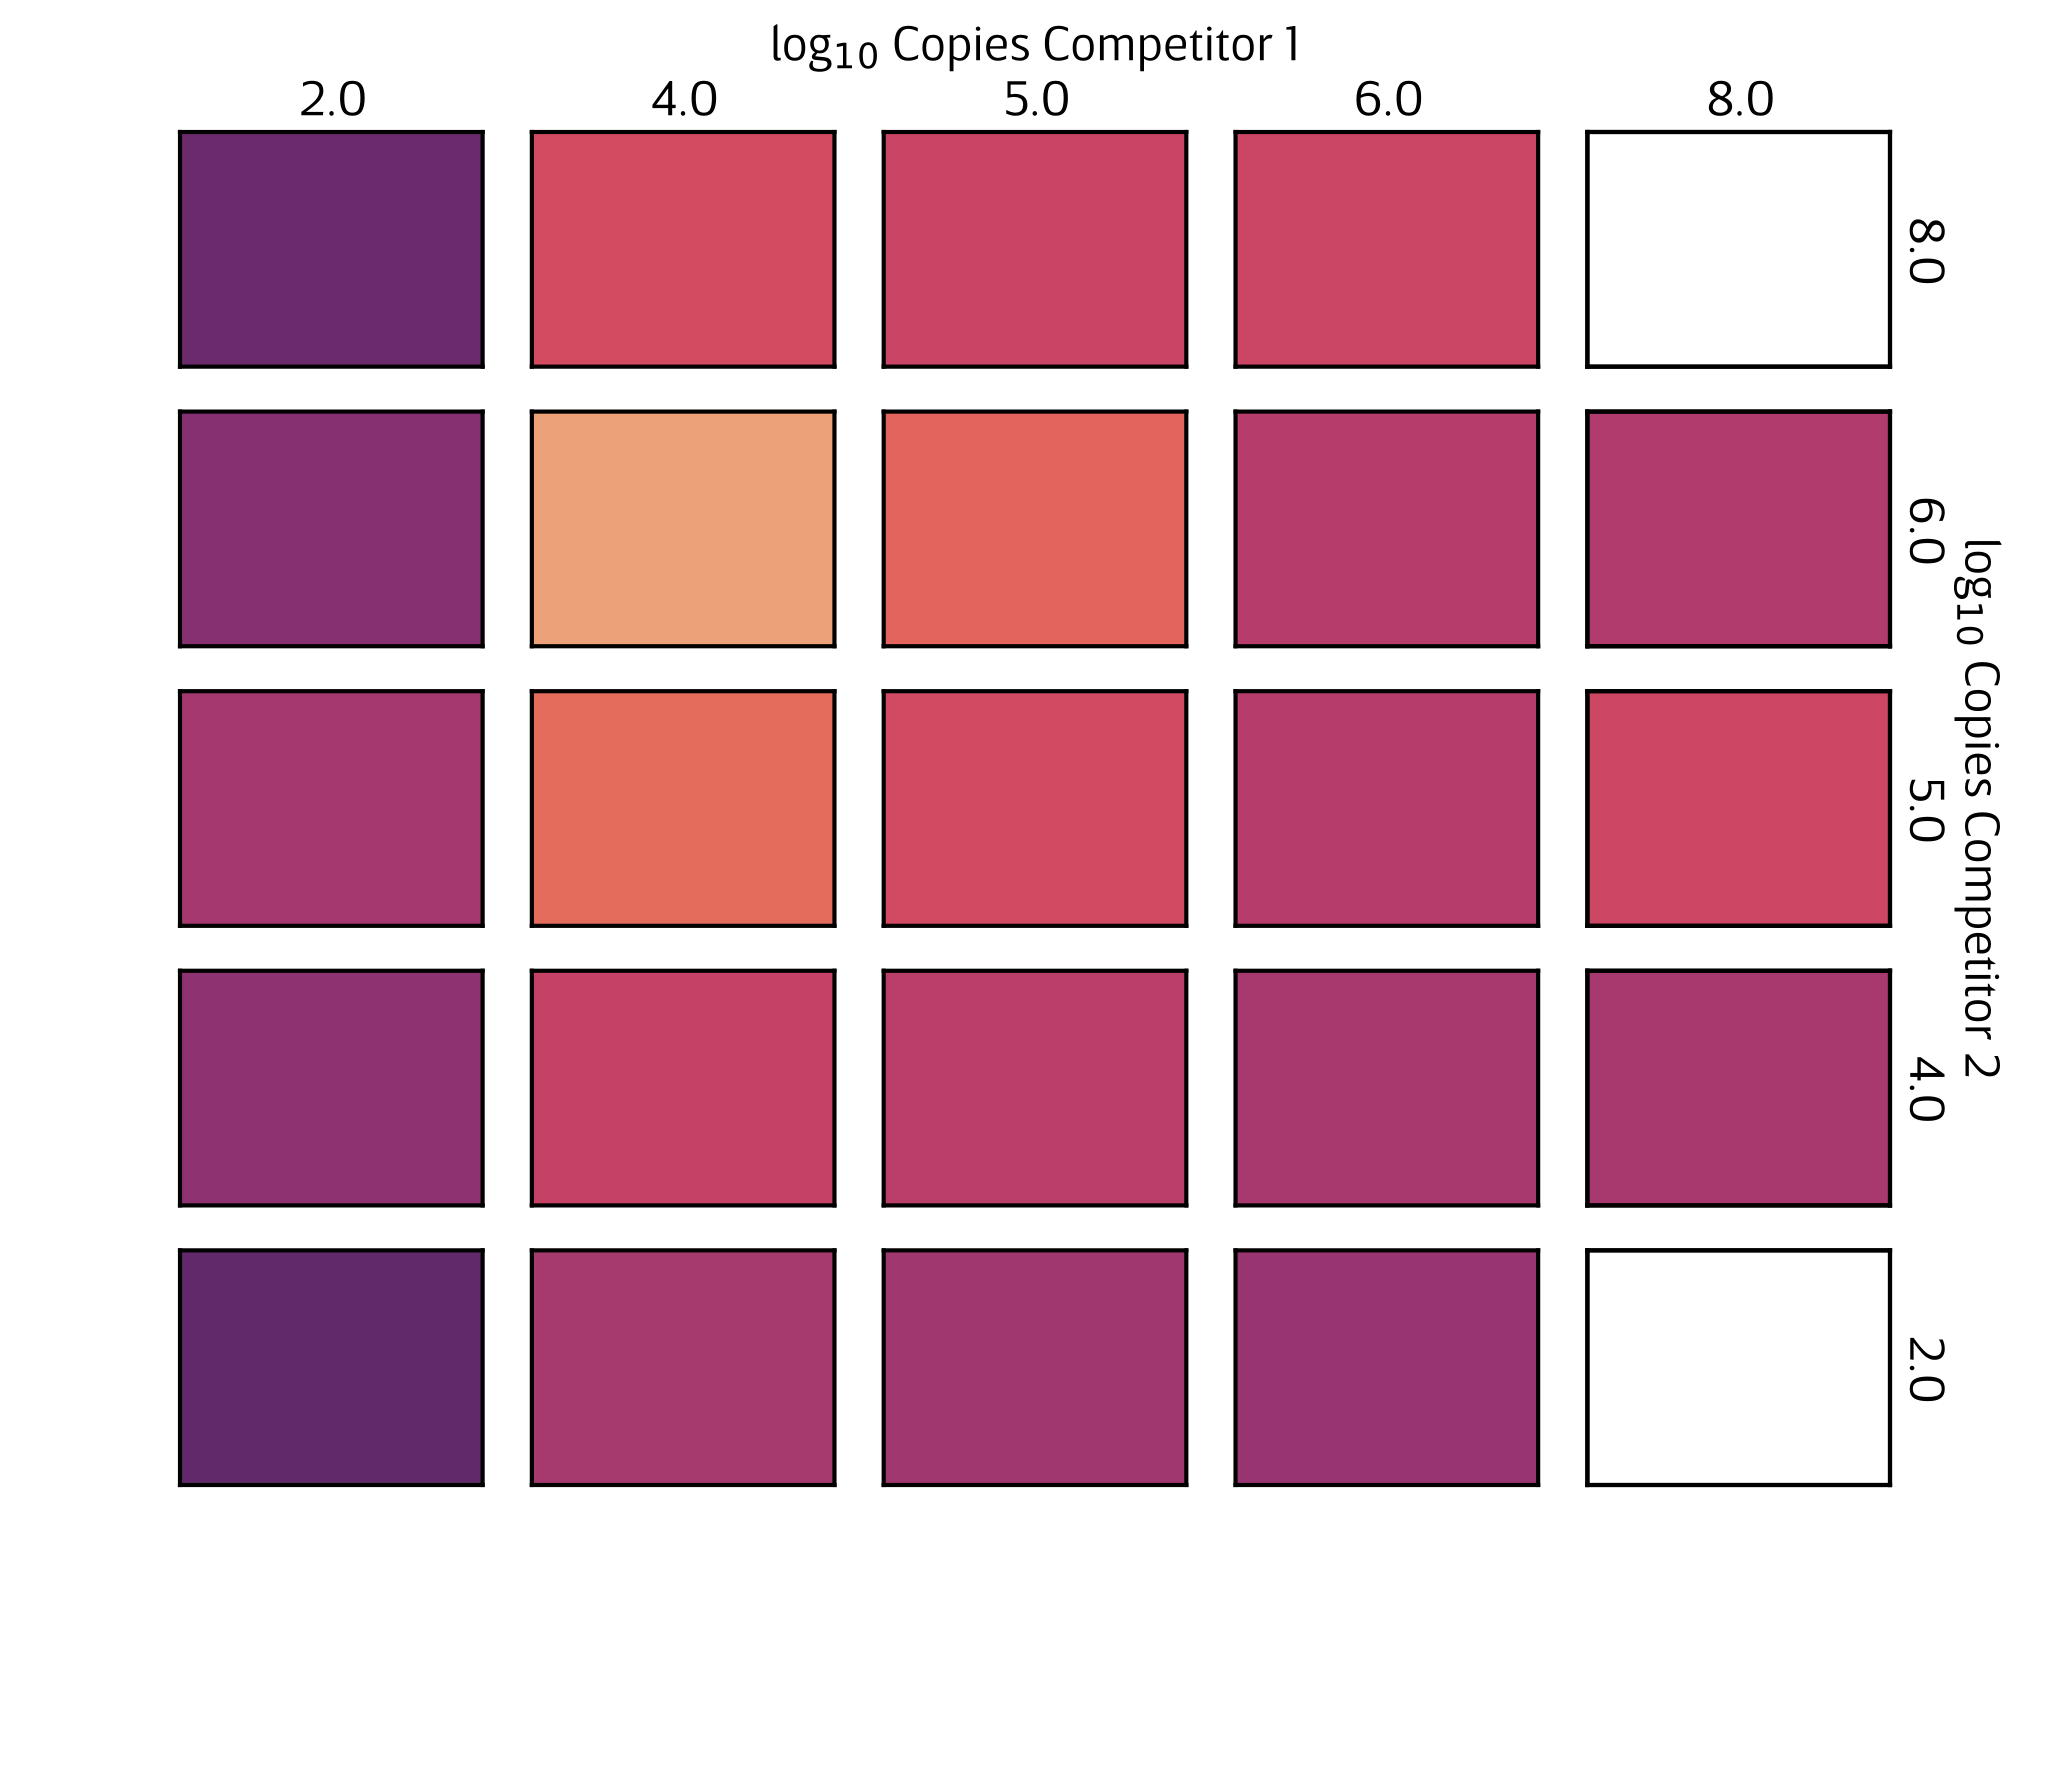

In [16]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}



for (rf2_lgQ, rf1_lgQ), ax in axes_dict.items():
    if (rf2_lgQ, rf1_lgQ) in rmses_antiparallel:
        rmse = rmses_antiparallel[(rf2_lgQ, rf1_lgQ)]
    else:
        ax.set_facecolor('white')
        continue
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    
format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5], hline=False)
plt.setp(
    axs,
    yticks=[],
    xticks=[],
)

print(f"RMSE Antiparallel: {np.mean(list(rmses_antiparallel.values())):.2f} ± {np.std(list(rmses_antiparallel.values())):.2f}")

savefig(plt.gcf(), alias="jagged_hermitcrab", transparent_svg=False)

Saving fig_S10E__linear_grasshopper__legend in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


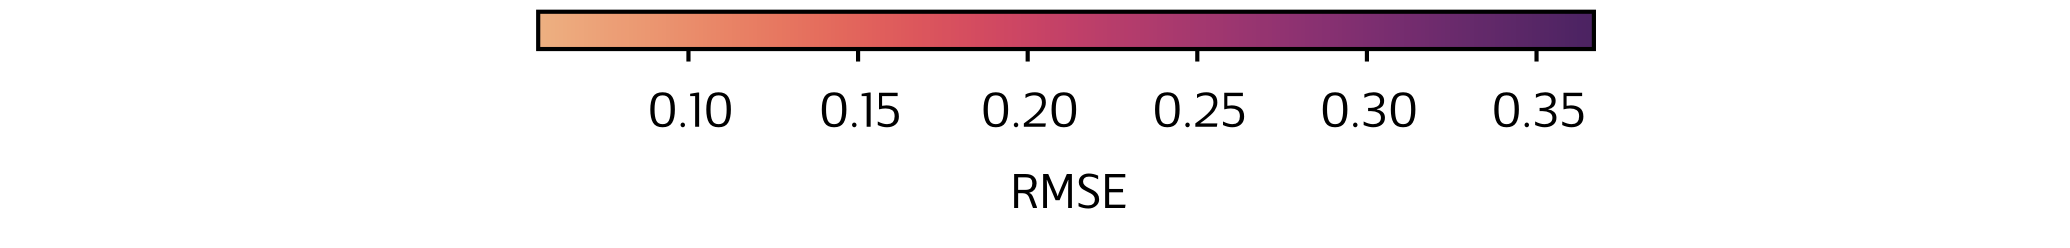

Saving fig_S10F__jagged_hermitcrab__legend in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


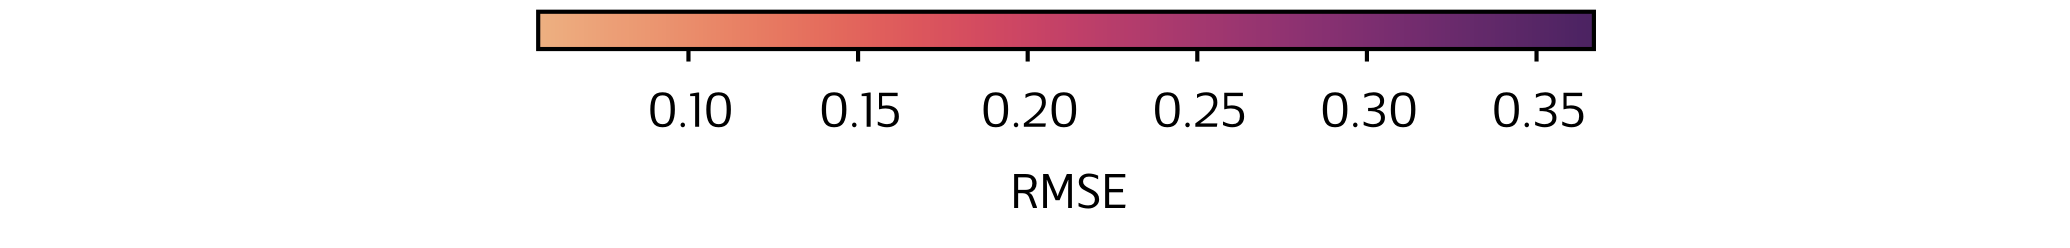

In [17]:
width = 3.45
height = 0.829 / 2
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

fig = plt.figure()
fig.set_figwidth(width)
fig.set_figheight(height)

ax = plt.axes([0.26, 0.8, 0.51, 0.15])

# Dummy data for the colorbar
dummy_data = np.array([0, 1])
norm = mpl.colors.Normalize(vmin=all_rmses.min(), vmax=all_rmses.max())

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set a dummy array for ScalarMappable

# Add the colorbar to the specified axes
cbar = fig.colorbar(
    sm, cax=ax, orientation="horizontal", shrink=0.6, aspect=20, pad=0.5
)

cbar.ax.tick_params(labelsize=ticklabelsize, width=0.5, length=1.5)
cbar.set_label("RMSE", fontsize=labelsize)

savefig(plt.gcf(), alias="linear_grasshopper", extra="legend")
savefig(plt.gcf(), alias="jagged_hermitcrab", extra="legend")